In [78]:
#DoorDash Arrival Time Prediction
import pandas as pd
import numpy as np
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [2]:
#Create a pandas dataframe 
dash_data = pd.read_csv("/Users/user/Downloads/historical_data.csv")
#print(dash_data.head(10))

dash_data = pd.DataFrame(dash_data)

print(dash_data.head(10))

   market_id           created_at actual_delivery_time  store_id  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:27:16      1845   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:56:29      5477   
2        3.0  2015-01-22 20:39:28  2015-01-22 21:09:09      5477   
3        3.0  2015-02-03 21:21:45  2015-02-03 22:13:00      5477   
4        3.0  2015-02-15 02:40:36  2015-02-15 03:20:26      5477   
5        3.0  2015-01-28 20:30:38  2015-01-28 21:08:58      5477   
6        3.0  2015-01-31 02:16:36  2015-01-31 02:43:00      5477   
7        3.0  2015-02-12 03:03:35  2015-02-12 03:36:20      5477   
8        2.0  2015-02-16 00:11:35  2015-02-16 00:38:01      5477   
9        3.0  2015-02-18 01:15:45  2015-02-18 02:08:57      5477   

  store_primary_category  order_protocol  total_items  subtotal  \
0               american             1.0            4      3441   
1                mexican             2.0            1      1900   
2                    NaN             1.0          

In [3]:
#convert times to datetime format so we can preform operation
dash_data['created_at'] = pd.to_datetime(dash_data['created_at'], format="%Y-%m-%d %H:%M:%S")
dash_data['actual_delivery_time'] = pd.to_datetime(dash_data['actual_delivery_time'], format="%Y-%m-%d %H:%M:%S")


#y = (dash_data['actual_delivery_time']-dash_data['created_at'])
#Insert a new column that represents the total time it takes to arrive
#We do this by subtracting the starting time and the actual delivery time
y =(dash_data['actual_delivery_time']-dash_data['created_at']).dt.total_seconds()
dash_data.insert(3 , "time_to_arrive" ,y)
print(dash_data)



        market_id          created_at actual_delivery_time  time_to_arrive  \
0             1.0 2015-02-06 22:24:17  2015-02-06 23:27:16          3779.0   
1             2.0 2015-02-10 21:49:25  2015-02-10 22:56:29          4024.0   
2             3.0 2015-01-22 20:39:28  2015-01-22 21:09:09          1781.0   
3             3.0 2015-02-03 21:21:45  2015-02-03 22:13:00          3075.0   
4             3.0 2015-02-15 02:40:36  2015-02-15 03:20:26          2390.0   
...           ...                 ...                  ...             ...   
197423        1.0 2015-02-17 00:19:41  2015-02-17 01:24:48          3907.0   
197424        1.0 2015-02-13 00:01:59  2015-02-13 00:58:22          3383.0   
197425        1.0 2015-01-24 04:46:08  2015-01-24 05:36:16          3008.0   
197426        1.0 2015-02-01 18:18:15  2015-02-01 19:23:22          3907.0   
197427        1.0 2015-02-08 19:24:33  2015-02-08 20:01:41          2228.0   

        store_id store_primary_category  order_protocol  total_

In [4]:
#Create a new feature that represents the number of availible doordashers (total_onshift_dashers - (total_busy_dashers))
total_free_dashers = dash_data["total_onshift_dashers"] - dash_data["total_busy_dashers"]
total_free_dashers
dash_data.insert(14 , "total_free_dashers" ,total_free_dashers)


In [5]:
dash_data.head(1)

,market_id,created_at,actual_delivery_time,time_to_arrive,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_free_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,3779.0,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,19.0,21.0,446,861.0


In [6]:
#Check how many Nulls in total
null_count = dash_data.isna().sum()
print(null_count)

market_id                                         987
created_at                                          0
actual_delivery_time                                7
time_to_arrive                                      7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_free_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64


In [7]:
#We notice some  categorical variables that we may want to one hot encode.  order_protocol , market_id , store_id, and store_primary_category
#Check unique values for store_id
dash_data["store_id"].nunique()

6743

In [8]:
dash_data["market_id"].nunique()

6

In [9]:
dash_data["store_primary_category"].nunique()

74

In [10]:
dash_data["order_protocol"].nunique()

7

In [11]:
#We want to avoid hot encoding feature vectors with large number of distinct values (curse of dimensionality) we know for a fact we can convert the order_protocol and the "market_id"
market_id_dummy = pd.get_dummies(dash_data["market_id"])
market_id_dummy = market_id_dummy.add_prefix("market_id_")




print(market_id_dummy)


        market_id_1.0  market_id_2.0  market_id_3.0  market_id_4.0  \
0                   1              0              0              0   
1                   0              1              0              0   
2                   0              0              1              0   
3                   0              0              1              0   
4                   0              0              1              0   
...               ...            ...            ...            ...   
197423              1              0              0              0   
197424              1              0              0              0   
197425              1              0              0              0   
197426              1              0              0              0   
197427              1              0              0              0   

        market_id_5.0  market_id_6.0  
0                   0              0  
1                   0              0  
2                   0              0  
3  

In [12]:
order_protocol_dummy = pd.get_dummies(dash_data["order_protocol"])
order_protocol_dummy = order_protocol_dummy.add_prefix("order_protocol_")
order_protocol_dummy

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
197423,0,0,0,1,0,0,0
197424,0,0,0,1,0,0,0
197425,0,0,0,1,0,0,0
197426,1,0,0,0,0,0,0


In [13]:
#We luckily have store_ids with known values for example for store_id (no NaNs) for example we have store_id 5477 that has already been identified as "mexican" 
#So we can fill the remaining values in accordingly.  
# use the fact that stores with the same "store_id" have the same "store_primary_category".  This isn't always the case we should first test this theory
unique1 = pd.unique(dash_data[["store_primary_category" , "store_id"]].values.ravel("K"))
print(len(unique1))

#Unique store_ids
print(len(dash_data["store_id"].unique()))

#As we can see there are some cases that we have the same store_id but different store_primary_category.  However this difference is very small so we can go ahead and assume that 
#store_id corresponds to the unique store_primary_category


6818
6743


In [14]:
#We can create a reference dictionary for all the store_ids
#First create a list of the unique values of store_id
unique_store_id = dash_data["store_id"].unique().tolist()
#Put them in a hash
store_id_hash = {store_id : (dash_data[dash_data.store_id == store_id].store_primary_category.mode()) for store_id in unique_store_id}
#After this each store_id will correspond to one store_primary cartegory


In [15]:
#Remember that we have some store_ids in which the mode of the primary category will be null since there is no other valid category
#Observe
print(store_id_hash[1845].size)
print(store_id_hash[3879].size)

1
0


In [16]:
#Create a list of the store_ids such that there are only null_values
null_list = []
for i in store_id_hash.keys():
    if store_id_hash[i].size == 0:
        null_list.append(i)


In [17]:

len(null_list)

#this list contains all such values that we only have null within the same store_id.  I.E there is no way to pinpoint a primary category
#174 is not a significant amount
#Delete these items from the hashmap and the dataframe.
for i in null_list:
    del store_id_hash[i]

store_id_hash



{1845: 0    american
 Name: store_primary_category, dtype: object,
 5477: 0     indian
 1    mexican
 Name: store_primary_category, dtype: object,
 2841: 0    italian
 Name: store_primary_category, dtype: object,
 4139: 0    mexican
 Name: store_primary_category, dtype: object,
 5058: 0    italian
 Name: store_primary_category, dtype: object,
 4149: 0    sandwich
 1        thai
 Name: store_primary_category, dtype: object,
 3201: 0    cafe
 Name: store_primary_category, dtype: object,
 5054: 0    italian
 Name: store_primary_category, dtype: object,
 2004: 0    american
 Name: store_primary_category, dtype: object,
 1984: 0    chinese
 Name: store_primary_category, dtype: object,
 4905: 0    mexican
 Name: store_primary_category, dtype: object,
 1698: 0    sandwich
 Name: store_primary_category, dtype: object,
 1936: 0    singaporean
 Name: store_primary_category, dtype: object,
 6015: 0    burger
 Name: store_primary_category, dtype: object,
 976: 0    breakfast
 Name: store_primary_c

In [18]:

#We need to parse out just the name
for i in store_id_hash.keys():
        store_id_hash[i] = store_id_hash[i].values[0]



In [19]:
store_id_hash

{1845: 'american',
 5477: 'indian',
 2841: 'italian',
 4139: 'mexican',
 5058: 'italian',
 4149: 'sandwich',
 3201: 'cafe',
 5054: 'italian',
 2004: 'american',
 1984: 'chinese',
 4905: 'mexican',
 1698: 'sandwich',
 1936: 'singaporean',
 6015: 'burger',
 976: 'breakfast',
 5081: 'mediterranean',
 1019: 'chinese',
 3994: 'japanese',
 6395: 'cafe',
 6517: 'american',
 6584: 'catering',
 4003: 'mexican',
 1848: 'sandwich',
 3654: 'filipino',
 6241: 'convenience-store',
 1521: 'american',
 5326: 'chinese',
 1203: 'indian',
 3155: 'sandwich',
 2527: 'greek',
 2183: 'american',
 2652: 'sandwich',
 3065: 'cafe',
 414: 'japanese',
 3468: 'other',
 5674: 'korean',
 2716: 'sandwich',
 4251: 'asian',
 1148: 'indian',
 4062: 'barbecue',
 280: 'mexican',
 2621: 'asian',
 2928: 'mexican',
 132: 'fast',
 2096: 'indian',
 5579: 'sandwich',
 6153: 'italian',
 2009: 'italian',
 2769: 'american',
 5667: 'chinese',
 4753: 'burger',
 3821: 'sandwich',
 1788: 'barbecue',
 5788: 'convenience-store',
 6115: 

In [20]:
#Add this to the data
dash_data["store_primary_category"]=dash_data["store_primary_category"].fillna(dash_data["store_id"].map(store_id_hash))

In [21]:
dash_data

,market_id,created_at,actual_delivery_time,time_to_arrive,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_free_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,3779.0,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,19.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,4024.0,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,-1.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,1781.0,5477,indian,1.0,1,1900,1,1900,1900,1.0,0.0,1.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,3075.0,5477,indian,1.0,6,6900,5,600,1800,1.0,1.0,0.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,2390.0,5477,indian,1.0,3,3900,3,1100,1600,6.0,6.0,0.0,9.0,446,650.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,1.0,2015-02-17 00:19:41,2015-02-17 01:24:48,3907.0,2956,fast,4.0,3,1389,3,345,649,17.0,17.0,0.0,23.0,251,331.0
197424,1.0,2015-02-13 00:01:59,2015-02-13 00:58:22,3383.0,2956,fast,4.0,6,3010,4,405,825,12.0,11.0,1.0,14.0,251,915.0
197425,1.0,2015-01-24 04:46:08,2015-01-24 05:36:16,3008.0,2956,fast,4.0,5,1836,3,300,399,39.0,41.0,-2.0,40.0,251,795.0
197426,1.0,2015-02-01 18:18:15,2015-02-01 19:23:22,3907.0,3630,sandwich,1.0,1,1175,1,535,535,7.0,7.0,0.0,12.0,446,384.0


In [22]:
#The actual delivery time and time to arrvive NaN values are very small so we can go ahead and delte these
dash_data.dropna(subset= "actual_delivery_time" , inplace=True)

print(dash_data.isna().sum())



market_id                                         987
created_at                                          0
actual_delivery_time                                0
time_to_arrive                                      0
store_id                                            0
store_primary_category                            867
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_free_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64


In [23]:
#We have cut our value of store_primary_category NaN values signifincantly for that category.  Thus the remaining values can be removed (much smaller portion of information lost)
dash_data.dropna(subset= "store_primary_category", inplace=True)

print(dash_data.isna().sum())

#Resolved the actual_delivery_time_column



market_id                                         986
created_at                                          0
actual_delivery_time                                0
time_to_arrive                                      0
store_id                                            0
store_primary_category                              0
order_protocol                                    992
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16160
total_busy_dashers                              16160
total_free_dashers                              16160
total_outstanding_orders                        16160
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      522
dtype: int64


In [24]:
#Actually found out we didn't have to delete as the one-hot-encode just ignores the Null values
#We hot encoded three variables, this will ignore some of the NaN values but this isn't a significant number (about 3000 obervations out of almost 200,000)
store_primary_cat_dummy = pd.get_dummies(dash_data["store_primary_category"])
store_primary_cat_dummy

,afghan,african,alcohol,alcohol-plus-food,american,argentine,asian,barbecue,belgian,brazilian,...,southern,spanish,steak,sushi,tapas,thai,turkish,vegan,vegetarian,vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197424,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197425,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
dash_data.head(1)

,market_id,created_at,actual_delivery_time,time_to_arrive,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_free_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,3779.0,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,19.0,21.0,446,861.0


In [26]:
#Add this data to our dataframe
#Also will remove the "store_id".  I suspect that the type of category the restaurant is in will have an effect on arrival time.  However the specific restaurant in that category 
#Probably wont make as much of a difference.
dash_data_train = dash_data.drop(columns=["store_primary_category","created_at","actual_delivery_time","market_id","store_id","order_protocol"])

dash_data_train = pd.concat([dash_data_train,market_id_dummy,order_protocol_dummy,store_primary_cat_dummy],axis =1)

In [27]:
dash_data_train.head(10)

,time_to_arrive,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_free_dashers,total_outstanding_orders,...,southern,spanish,steak,sushi,tapas,thai,turkish,vegan,vegetarian,vietnamese
0,3779.0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,19.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4024.0,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,-1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1781.0,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3075.0,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2390.0,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2300.0,3.0,5000.0,3.0,1500.0,1900.0,2.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1584.0,2.0,3900.0,2.0,1200.0,2700.0,10.0,9.0,1.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1965.0,4.0,4850.0,4.0,750.0,1800.0,7.0,8.0,-1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1586.0,4.0,4771.0,3.0,820.0,1604.0,8.0,6.0,2.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3192.0,2.0,2100.0,2.0,700.0,1200.0,2.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
#now we have to do something about the missing total_onshift_dashers and all values having to do with it
#We do notice we have some negative values for the total_free_dashers.  This doesnt make sense so we also have to remedy this
dash_data_train.loc[dash_data_train["total_free_dashers"]<0 , "total_free_dashers"]
#Negative number of total free dashers makes no sense.  We can instead change these values to 0 since both a negative value and 0 represent no availible dashers
dash_data_train.loc[dash_data_train["total_free_dashers"]<0 , "total_free_dashers"] = 0

#Next we can change the total_busy_dashers.  If total_busy_dashers > total_onshift_dashers then we should equalize them
dash_data_train.loc[dash_data_train["total_busy_dashers"]>dash_data_train["total_onshift_dashers"] , "total_busy_dashers"] = dash_data_train["total_onshift_dashers"]

#We can drop the remaining NaN values
dash_data_train.dropna(subset= "total_free_dashers", inplace=True)
dash_data_train.dropna(subset='estimated_store_to_consumer_driving_duration', inplace=True)
dash_data_train.isna().sum()


time_to_arrive        0
total_items           0
subtotal              0
num_distinct_items    0
min_item_price        0
                     ..
thai                  0
turkish               0
vegan                 0
vegetarian            0
vietnamese            0
Length: 99, dtype: int64

In [52]:
#Data is now clean and ready for visualization
dash_data_train.shape

(179915, 99)

In [53]:
#Data visualization
#First thing we can look at is the correlation of the variables.  Off the bat I think we can do without total_onshift_dashers	total_busy_dashers	total_free_dashers 
#however we should first visualize the correlation of all the relevant features of the data
corr_dash = dash_data_train.corr()


<AxesSubplot:>

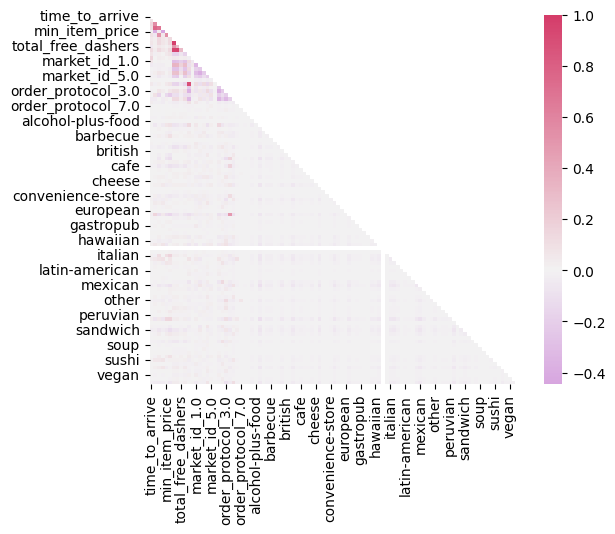

In [59]:
#plot a correlation heatmap
#First want to get rid of redundances in the correlation matrix
#The standard heat map will have a duplicate 'triangle' on top of it, we should delete this by using a mask
#this function will take the lower traingle of such values that share the same corr_values and change them to True (we want to indicate this to the mask call in the heatmap function)
mask= np.triu(np.ones_like(corr_dash , dtype= bool))
plt.plot(figsize = (20,20))
cmap = sns.diverging_palette(300, 0,as_cmap=True)
sns.heatmap(corr_dash , mask = mask , cmap = cmap ,square=True ,vmax=1, center=0)


In [55]:
#We know a value between hawaiian and italian has no values and is worth dropping (perhaps a feature that no longer has any rows in our data but is still present as a column)
#We only have two options indian and indonesian, however it must be indonesian since we can see from the head of the data set India is indeed present
dash_data_train["indonesian"].describe()
dash_data_train.drop(columns="indonesian")




,time_to_arrive,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_free_dashers,total_outstanding_orders,...,southern,spanish,steak,sushi,tapas,thai,turkish,vegan,vegetarian,vietnamese
0,3779.0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,19.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4024.0,1.0,1900.0,1.0,1400.0,1400.0,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1781.0,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3075.0,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2390.0,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,3907.0,3.0,1389.0,3.0,345.0,649.0,17.0,17.0,0.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197424,3383.0,6.0,3010.0,4.0,405.0,825.0,12.0,11.0,1.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197425,3008.0,5.0,1836.0,3.0,300.0,399.0,39.0,39.0,0.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197426,3907.0,1.0,1175.0,1.0,535.0,535.0,7.0,7.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
#First we want to remove the redundancies in our correlation matrix
def remove_redundant(df):
    labels_drop = set()
    col = df.columns
#Want to iterate through the columns
    for i in range(df.shape[1]):
        for j in range(0,i+1):
        #Add to the drop list all the values on the diagnal and above.  Since we will have redundant terms
            labels_drop.add((col[i] , col[j]))
    return labels_drop

def create_corr_ranking(df , n=10):
    #Get the absolute value of the correlation matrix and format it as a vertical list
    abs_corr = df.corr().abs().unstack()
    #Call the function we used recently to remove duplicated
    drop = remove_redundant(df)
    #Drop all the redundant (and identity) pairs and make sure to from highest to smallest
    abs_corr = abs_corr.drop(labels = drop).sort_values(ascending = False)
    return abs_corr[0:n]

rank_dash = create_corr_ranking(dash_data_train , n=10)

print(rank_dash)



            


total_onshift_dashers           total_busy_dashers          0.970513
total_busy_dashers              total_outstanding_orders    0.959715
total_onshift_dashers           total_outstanding_orders    0.936067
estimated_order_place_duration  order_protocol_1.0          0.896189
total_items                     num_distinct_items          0.759831
                                                              ...   
indonesian                      thai                             NaN
                                turkish                          NaN
                                vegan                            NaN
                                vegetarian                       NaN
                                vietnamese                       NaN
Length: 4851, dtype: float64


In [65]:
#We can see that as expected there is a very high correlation on the total_on_shift_dashers, total_busy_dashers 
dash_data_train.drop(columns=["total_onshift_dashers","total_busy_dashers"])



,time_to_arrive,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_free_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,southern,spanish,steak,sushi,tapas,thai,turkish,vegan,vegetarian,vietnamese
0,3779.0,4.0,3441.0,4.0,557.0,1239.0,19.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4024.0,1.0,1900.0,1.0,1400.0,1400.0,0.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1781.0,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3075.0,6.0,6900.0,5.0,600.0,1800.0,0.0,2.0,446.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2390.0,3.0,3900.0,3.0,1100.0,1600.0,0.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,3907.0,3.0,1389.0,3.0,345.0,649.0,0.0,23.0,251.0,331.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197424,3383.0,6.0,3010.0,4.0,405.0,825.0,1.0,14.0,251.0,915.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197425,3008.0,5.0,1836.0,3.0,300.0,399.0,0.0,40.0,251.0,795.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197426,3907.0,1.0,1175.0,1.0,535.0,535.0,0.0,12.0,446.0,384.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:

dash_data_train.info()
#Make the data type consistent throughout
dash_data_train = dash_data_train.astype('float64')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 179915 entries, 0 to 197427
Data columns (total 99 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   time_to_arrive                                179915 non-null  float64
 1   total_items                                   179915 non-null  float64
 2   subtotal                                      179915 non-null  float64
 3   num_distinct_items                            179915 non-null  float64
 4   min_item_price                                179915 non-null  float64
 5   max_item_price                                179915 non-null  float64
 6   total_onshift_dashers                         179915 non-null  float64
 7   total_busy_dashers                            179915 non-null  float64
 8   total_free_dashers                            179915 non-null  float64
 9   total_outstanding_orders                      17

[[-1.75933944  1.69189807]
 [-1.56268624 -1.52970218]
 [-2.82247531 -0.68622911]
 ...
 [-1.51471721  0.58595348]
 [-3.23754138 -0.80669421]
 [-2.53282518  1.06647833]]


(0.0, 15.0)

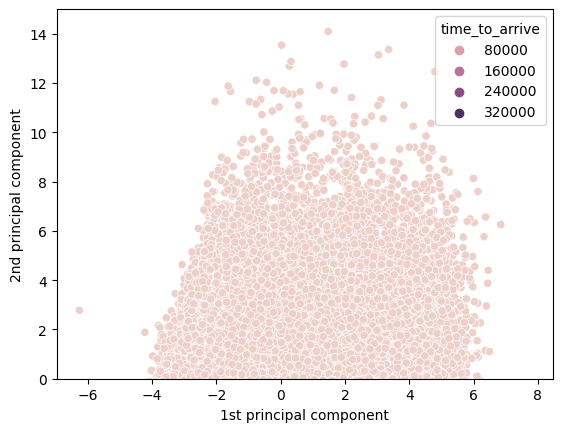

In [114]:
#Use PCA to visualize the data
#scale the data
scale =StandardScaler()
scaled_dash = scale.fit_transform(dash_data_train)

scaled_dash_data = pd.DataFrame(scaled_dash , columns=dash_data_train.columns)

#use principal component (one compoent) to see the general trend of all the features vs the time_to_arrive

pca = PCA(n_components=2)

principal_dash = pca.fit_transform(scaled_dash_data)

print(principal_dash)
#Create a data frame
dash_pca = pd.DataFrame(data = principal_dash, columns=["1st principal component" , "2nd principal component"])
#plot
sns.scatterplot(x="1st principal component",y ="2nd principal component",data = dash_pca)
plt.ylim(0,15)